In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
%matplotlib inline
import glob
import conx as cx
import os
import urllib.request as urllib
import tensorflow

Using TensorFlow backend.
ConX, version 3.7.7


In [2]:
# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'

In [3]:
# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

In [4]:
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(everything, (-1, 3, 96, 96))
        images = np.transpose(images, (0, 3, 2, 1))
        return images

In [5]:
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

In [6]:
def read_single_image(image_file):
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    return image

In [7]:
def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

In [8]:
def save_image(image, name):
    imsave("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1

In [11]:
# test to check if the whole dataset is read correctly
images = read_all_images(DATA_PATH)
print(images.shape)

labels = read_labels(LABEL_PATH)
print(labels.shape)

(5000, 96, 96, 3)
(5000,)


In [12]:
# Create target array as an array of arrays that nessesary for the model
target = []
labels_array = np.zeros(10, dtype=int)
for label in labels:
    labels_array[label-1] = 1
    target.append(labels_array)
    labels_array = np.zeros(10, dtype=int)

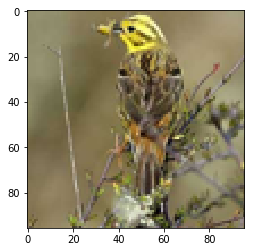

[0 1 0 0 0 0 0 0 0 0]


In [13]:
plot_image(images[0])
print(target[0])

Immage shape - (96, 96, 3)
Labels type - numoy.unit8


In [14]:
net = cx.Network('STL-10ImageClasses')
net.dataset.clear()

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
for i in range(0, 1000):
    inputs = images[i]
    targets = target[i]
    net.dataset.append(inputs, targets)
    

In [16]:
type(net.dataset)

conx.dataset.Dataset

In [17]:
net.dataset.info()

**Dataset**: Dataset for STL-10ImageClasses

**Information**:
   * name    : None
   * length  : 1000

**Input Summary**:
   * shape  : (96, 96, 3)
   * range  : (0, 255)

**Target Summary**:
   * shape  : (10,)
   * range  : (0, 1)



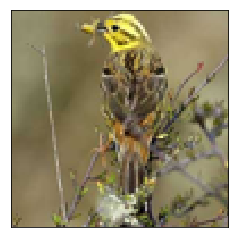

In [18]:
cx.view(net.dataset.inputs[0])

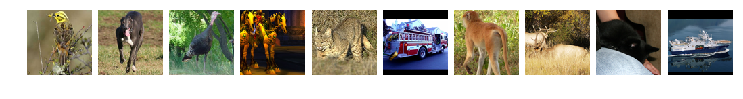

In [19]:
cx.view(net.dataset.inputs[0:10], layout=(1,10))

In [20]:
print(net.dataset.targets[0:10])

[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]


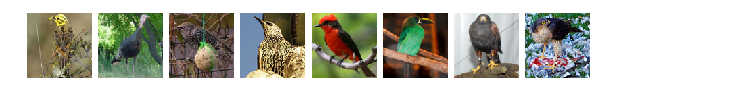

In [21]:
bird = [i for i in range(40) if net.dataset.targets[i][1] == 1]
cx.view([cx.array_to_image(v) for v in net.dataset.inputs[bird]], layout = (1, 10))

In [22]:
net.dataset.split()

(1000, 0)

In [23]:
net.dataset.split(300)
net.dataset.split()

(700, 300)

In [24]:
print(len(net.dataset.inputs), 'total images')
print(len(net.dataset.train_inputs), 'images for training')
print(len(net.dataset.test_inputs), 'images for testing')

1000 total images
700 images for training
300 images for testing


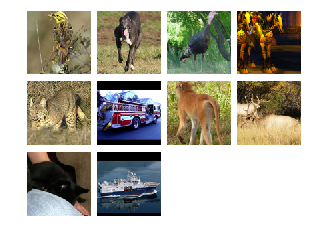

[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]


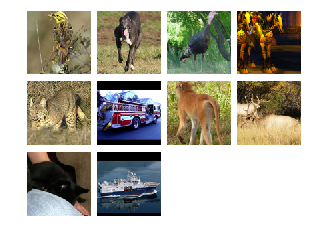

[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]


In [25]:
cx.view(net.dataset.inputs[0:10])
print(net.dataset.targets[0:10])
cx.view(net.dataset.train_inputs[0:10]) 
print(net.dataset.train_targets[0:10])

In [26]:
net.add(cx.Layer("input", (96,96,3)),
        cx.Conv2DLayer("conv2D_1", 32, (5,5), strides=1, padding='same', activation="relu"),
        cx.Conv2DLayer("conv2D_2", 32, (5,5), strides=1, padding='same', activation="relu"),
        cx.MaxPool2DLayer("maxpool_1", (2,2), strides=2, padding='same', dropout=0.25),
        cx.FlattenLayer("flat"),
        cx.Layer("hidden", 512, activation='relu', vshape=(16, 32), dropout=0.5),
        cx.Layer("hidden2", 50, activation='relu', vshape=(10, 5), dropout=0.5),
        cx.Layer("output", 10, activation='softmax'))


# creates connections between layers in the order they were added
net.connect()
        


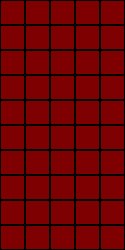
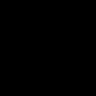

In [27]:
net.picture()

In [ ]:
#net.set_dataset(net.dataset)

The model should be compile with chosen loss function 'categorical_ crossentropy', which corrisponding to our activation function.

In [28]:
net.compile(error='categorical_crossentropy', optimizer='rmsprop', lr=0.0001, decay=1e-6)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
net.propagate(net.dataset.inputs[0])

In [ ]:
net.picture(net.dataset.inputs[0], scale = 0.5)

In [31]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

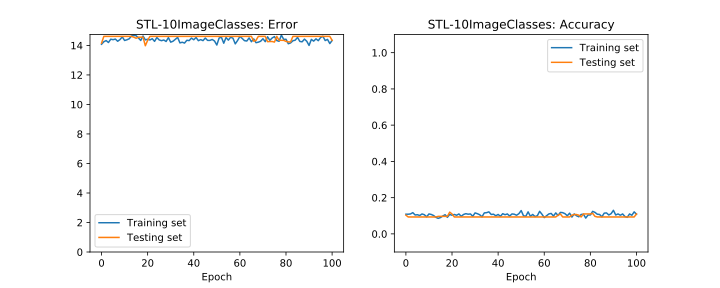

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#  100 |  14.33574 |   0.10857 |  14.34511 |   0.11000 


In [29]:
net.train(100, batch_size=100, record=1)


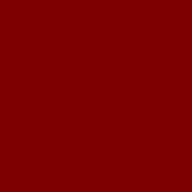
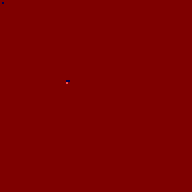
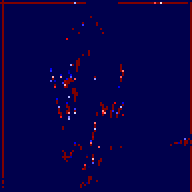
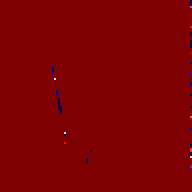
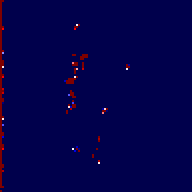
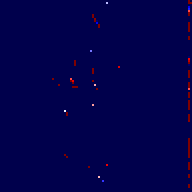
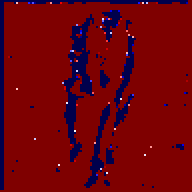
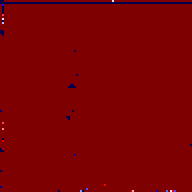
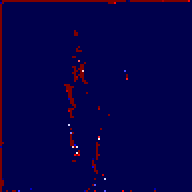
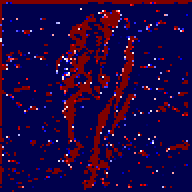
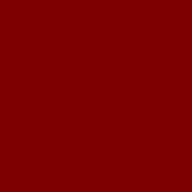
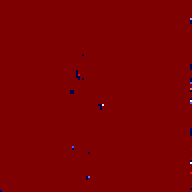
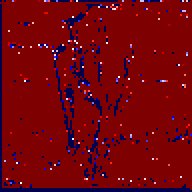
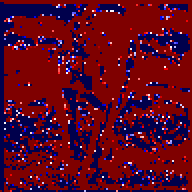
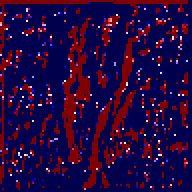
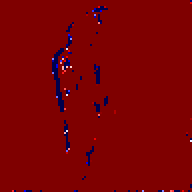
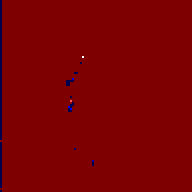
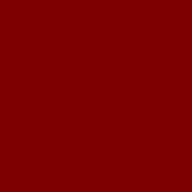
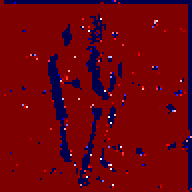
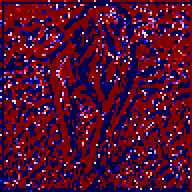
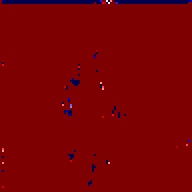
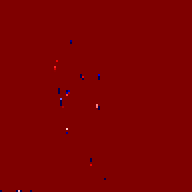
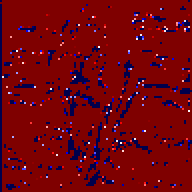
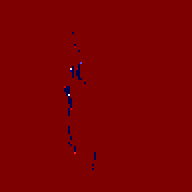
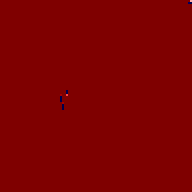
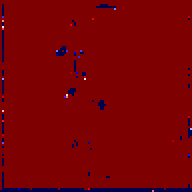
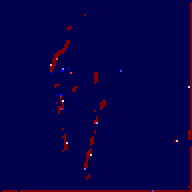
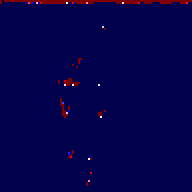
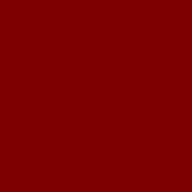
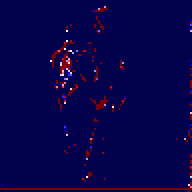
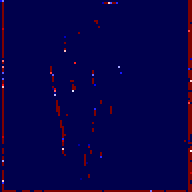
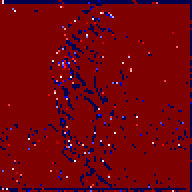

In [35]:
net.propagate_to_features("conv2D_1", net.dataset.inputs[1], scale=2)